# TA-11 ANN Klasifikasi Biner – Prediksi Stroke (Dataset Kaggle)

Notebook ini mengikuti instruksi TA:
- Imputasi missing values (tanpa NaN)
- Encoding: LabelEncoder (target), One-Hot Encoding (fitur kategorikal)
- Feature scaling (StandardScaler) **fit di train saja** (menghindari data leakage)
- Split: train/test + validation via `validation_split` saat training
- Model ANN Sequential (≥2 hidden layer ReLU) + output Sigmoid
- Compile Adam + loss `binary_crossentropy`
- Training dengan EarlyStopping (epochs diset 100 agar sesuai arahan, stop otomatis)
- Evaluasi: learning curves, confusion matrix, classification report
- Penanganan imbalance: `class_weight` (opsional tapi direkomendasikan)

**Dataset Kaggle:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  
Pastikan file CSV bernama `healthcare-dataset-stroke-data.csv` berada di folder yang sama dengan notebook ini (atau ubah `DATA_PATH`).


In [3]:
# 1) Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(0)
tf.random.set_seed(42)

plt.rcParams["figure.figsize"] = (8, 5)

In [4]:
# 2) Load dataset
DATA_PATH = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# 3) EDA singkat
print("Shape dataset:", df.shape)
df.info()

print("\nJumlah missing value per kolom:")
print(df.isna().sum())

print("\nDistribusi target (stroke):")
print(df["stroke"].value_counts())

Shape dataset: (5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Jumlah missing value per kolom:
id                     0
gender                 0
age                    0
hypertension           

In [6]:
# 4) Pisahkan fitur (X) dan target (y)
X = df.drop(columns=["stroke"]).copy()
y_raw = df["stroke"].copy()

# Opsional tapi disarankan: buang kolom ID jika ada (identifier, bukan fitur prediktif)
if "id" in X.columns:
    X = X.drop(columns=["id"])

# 5) Split dulu (menghindari data leakage pada imputasi & scaling)
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw,
    test_size=0.2,
    random_state=42,
    stratify=y_raw
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (4088, 10) | Test shape: (1022, 10)


In [7]:
# 6) Handling Missing Values (fit dari TRAIN, terapkan ke TEST)
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# Numerik -> median (berdasarkan TRAIN)
for col in num_cols:
    med = X_train[col].median()
    X_train[col] = X_train[col].fillna(med)
    X_test[col] = X_test[col].fillna(med)

# Kategorikal -> modus (berdasarkan TRAIN)
for col in cat_cols:
    mode_val = X_train[col].mode(dropna=True)[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)

print("Total NaN TRAIN:", int(X_train.isna().sum().sum()))
print("Total NaN TEST :", int(X_test.isna().sum().sum()))

Total NaN TRAIN: 0
Total NaN TEST : 0


In [8]:
# 7) Encoding
# 7.1 Target biner -> LabelEncoder (sesuai instruksi TA)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# 7.2 One-Hot Encoding untuk fitur kategorikal (pd.get_dummies)
X_train_enc = pd.get_dummies(X_train, columns=cat_cols)
X_test_enc  = pd.get_dummies(X_test, columns=cat_cols)

# Pastikan kolom train dan test sama (align)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join="left", axis=1, fill_value=0)

print("Encoded train shape:", X_train_enc.shape, "| Encoded test shape:", X_test_enc.shape)

Encoded train shape: (4088, 21) | Encoded test shape: (1022, 21)


In [9]:
# 8) Feature Scaling (WAJIB): fit di TRAIN saja, transform TRAIN & TEST
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc).astype("float32")
X_test_scaled  = scaler.transform(X_test_enc).astype("float32")

In [10]:
# 9) Penanganan Imbalanced Data (opsional tapi disarankan): class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))

print("Class distribution (train):", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class weight:", class_weight)

Class distribution (train): {0: 3889, 1: 199}
Class weight: {0: 0.5255849832861919, 1: 10.271356783919598}


In [11]:
# 10) Bangun model ANN (Sequential)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# 11) Compile (Adam + binary_crossentropy untuk klasifikasi biner)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1408      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3521 (13.75 KB)
Trainable params: 3521 (13.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# 12) Training
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,              # sesuai arahan TA (misal 50-100); stop otomatis via EarlyStopping
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

Epoch 1/100


103/103 [==============================] - 3s 8ms/step - loss: 0.6468 - accuracy: 0.6364 - val_loss: 0.5691 - val_accuracy: 0.6919
Epoch 2/100
103/103 [==============================] - 0s 5ms/step - loss: 0.5642 - accuracy: 0.6434 - val_loss: 0.5371 - val_accuracy: 0.6797
Epoch 3/100
103/103 [==============================] - 1s 5ms/step - loss: 0.5396 - accuracy: 0.6651 - val_loss: 0.5005 - val_accuracy: 0.7274
Epoch 4/100
103/103 [==============================] - 1s 5ms/step - loss: 0.5360 - accuracy: 0.6798 - val_loss: 0.4926 - val_accuracy: 0.7359
Epoch 5/100
103/103 [==============================] - 1s 5ms/step - loss: 0.5190 - accuracy: 0.6951 - val_loss: 0.4951 - val_accuracy: 0.7384
Epoch 6/100
103/103 [==============================] - 1s 5ms/step - loss: 0.5146 - accuracy: 0.6917 - val_loss: 0.4857 - val_accuracy: 0.7396
Epoch 7/100
103/103 [==============================] - 1s 5ms/step - loss: 0.4983 - accuracy: 0.7067 - val_loss: 0.4558 - val_accuracy: 0.76

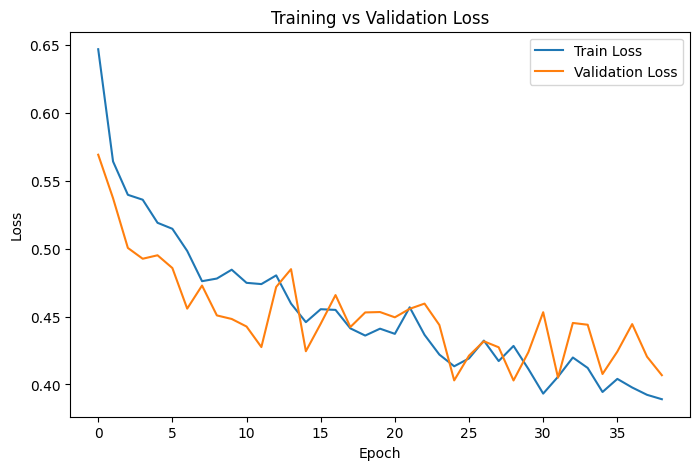

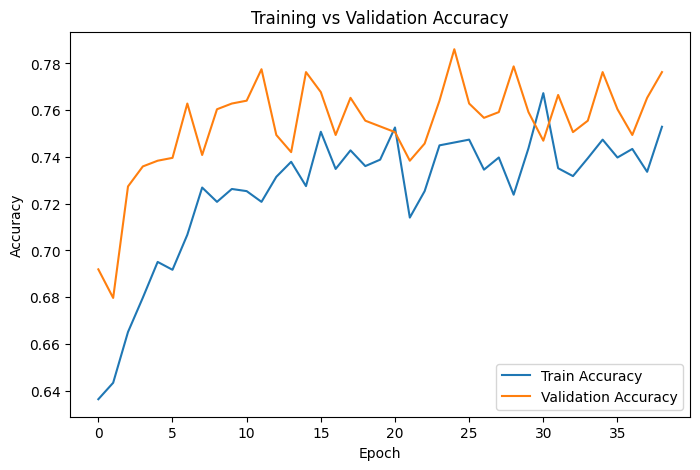

In [13]:
# 13) Visualisasi Learning Curves (Loss & Accuracy)
history_df = pd.DataFrame(history.history)

plt.figure()
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_df["accuracy"], label="Train Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Catatan analisis (untuk laporan):
# - Jika train loss turun tapi val loss naik -> indikasi overfitting.
# - Jika kedua loss tinggi dan tidak turun -> indikasi underfitting (atau perlu tuning).

Classification Report:
              precision    recall  f1-score   support

           0     0.9813    0.7572    0.8548       972
           1     0.1324    0.7200    0.2236        50

    accuracy                         0.7554      1022
   macro avg     0.5568    0.7386    0.5392      1022
weighted avg     0.9398    0.7554    0.8239      1022



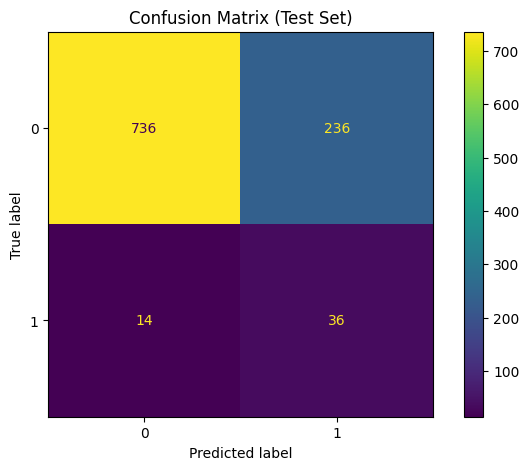

In [14]:
# 14) Evaluasi pada Test Set (Confusion Matrix + Classification Report)
y_prob = model.predict(X_test_scaled, verbose=0).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [15]:
# 15) SIMPAN ARTIFACT untuk DEPLOYMENT (model, scaler, dan kolom fitur)
import joblib

# Simpan model ANN
model.save("model_stroke.h5")

# Simpan scaler
joblib.dump(scaler, "scaler.pkl")

# Simpan daftar kolom hasil one-hot encoding (agar input app bisa di-align)
if hasattr(scaler, "feature_names_in_"):
    print("✅ scaler.feature_names_in_ tersimpan. Jumlah fitur:", len(scaler.feature_names_in_))
else:
    print("⚠️ scaler tidak menyimpan feature_names_in_. Pastikan scaler.fit_transform inputnya DataFrame!")


print("✅ Saved: model_stroke.h5, scaler.pkl, columns.json")


✅ scaler.feature_names_in_ tersimpan. Jumlah fitur: 21
✅ Saved: model_stroke.h5, scaler.pkl, columns.json


c:\Users\Purnamasari Siregar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
